In [25]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import torch
plt.rcParams['font.sans-serif'] = ['SimHei']#绘图显示中文
plt.rc('font',family='Times New Roman')

In [26]:
df = pd.read_csv(r"..\data\output.csv", sep=',')

In [27]:
df.head(10)

,1,1.1,0,2.0192,0.168,0.005,0.005.1,0.03,0.154,0.154.1,0.021,0.046,0.1,0.466,0.2,0.3,0.4,0.5,0.6,1.2
0,1,1,0,2.3652,0.168,0.012,0.012,0.089,0.151,0.151,0.019,0.037,0.0,0.470,0,0,0,0,0,1.0
1,1,1,0,1.9010,0.168,0.083,0.083,0.145,0.162,0.152,0.000,0.000,0.0,0.018,0,0,0,0,0,0.0
2,1,1,0,1.6903,0.007,0.000,0.000,0.000,0.330,0.330,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
3,1,1,0,1.9215,0.007,0.003,0.003,0.015,0.151,0.152,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
4,1,1,0,1.4449,0.007,0.000,0.000,0.000,0.152,0.154,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
5,1,1,0,1.8535,0.007,0.007,0.007,0.016,0.152,0.152,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
6,1,1,0,1.8051,0.007,0.002,0.002,0.004,0.246,0.246,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
7,1,1,0,1.5071,0.169,0.192,0.192,0.038,0.154,0.153,0.000,0.000,0.0,0.013,1,0,0,0,0,0.0
8,1,1,0,1.8997,0.169,0.000,0.000,0.000,0.235,0.239,0.000,0.000,0.0,0.000,0,0,0,0,0,0.0
9,1,1,0,1.9275,0.150,0.063,0.063,0.110,0.123,0.151,0.000,0.002,0.0,0.001,0,0,0,0,0,0.0


In [28]:
df.columns=['islocal','direct','isserver','duration','framesizeration_in','framesizeratio_out','localdelayavg','localdelaynavg',
            'remotedelayavg','remotedelaynavg','dupack','retrans','malf','outoforder','localdelay_label','remotedelay_label',
            'dupack_label','retrans_label','malf_label','outoforder_label']
 
df_filled = df.fillna(0)

feature_column=df_filled.columns[:14]
# 这里下面对数据的处理能被raw_feature迁移识别吗？
raw_feature=df_filled[feature_column]

标准化


In [29]:

from sklearn.preprocessing import StandardScaler
import numpy as np

# 创建一个StandardScaler对象
scaler = StandardScaler()

# 使用fit_transform方法对数据进行标准化
scaled_feature = scaler.fit_transform(raw_feature.iloc[:,[3,4,5,6,7,8,9,10,11,12,13]])

print(f'scaled_feature: {scaled_feature}')

df_scale=df_filled  # 为了不改变原始数据，这里复制一份
print(f'df_scale: {df_scale}')

df_scale.iloc[:,[3,4,5,6,7,8,9,10,11,12,13]]=scaled_feature  # 将标准化后的数据替换原始数据
# print(f'df_scale: {df_scale}')  # (2971, 20)


scaled_feature: [[ 3.74844116  3.31904904  0.04876494 ... -1.65627883 -0.10690365
  -1.65443149]
 [ 2.93605212  3.31904904  2.91924971 ... -1.65627914 -0.10690365
  -1.65446434]
 [ 2.56730939 -0.20138291 -0.43638742 ... -1.65627914 -0.10690365
  -1.65446565]
 ...
 [-0.39085777 -0.35444517 -0.15338188 ... -1.65627914 -0.10690365
  -1.65446565]
 [-0.39085777 -0.35444517 -0.15338188 ... -1.65627914 -0.10690365
  -1.65446565]
 [-0.39085777 -0.35444517 -0.15338188 ... -1.65627914 -0.10690365
  -1.65446565]]
df_scale:        islocal  direct  isserver  duration  framesizeration_in  \
0            1       1         0    2.3652               0.168   
1            1       1         0    1.9010               0.168   
2            1       1         0    1.6903               0.007   
3            1       1         0    1.9215               0.007   
4            1       1         0    1.4449               0.007   
...        ...     ...       ...       ...                 ...   
55530        1      

# 划分数据集

In [30]:
import torch

def calculate_accuracy(labels,outputs):
    """
    计算准确率。
    outputs: 模型输出，形状为 (batch_size, num_classes)。
    labels: 真实标签，形状为 (batch_size,)。
    """
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def calculate_f1_score(labels,outputs):
    """
    计算F1分数。
    outputs: 模型输出，形状为 (batch_size, num_classes)。
    labels: 真实标签，形状为 (batch_size,)。
    """
    _, predicted = torch.max(outputs, 1)
    
    # 计算TP, FP, FN
    tp = ((predicted == 1) & (labels == 1)).sum().item()
    fp = ((predicted == 1) & (labels == 0)).sum().item()
    fn = ((predicted == 0) & (labels == 1)).sum().item()
    
    # 计算精确率和召回率
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # 计算F1分数
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score


# model

In [31]:
df_scale.iloc[:, :14]

,islocal,direct,isserver,duration,framesizeration_in,framesizeratio_out,localdelayavg,localdelaynavg,remotedelayavg,remotedelaynavg,dupack,retrans,malf,outoforder
0,1,1,0,3.748441,3.319049,0.048765,-0.221588,1.510899,-2.076983,2.368498,-1.218051,-1.656279,-0.106904,-1.654431
1,1,1,0,2.936052,3.319049,2.919250,2.121231,2.643827,-1.797843,2.389255,-1.221644,-1.656279,-0.106904,-1.654464
2,1,1,0,2.567309,-0.201383,-0.436387,-0.617557,-0.289648,2.465389,6.084035,-1.221644,-1.656279,-0.106904,-1.654466
3,1,1,0,2.971929,-0.201383,-0.315099,-0.518565,0.013815,-2.076983,2.389255,-1.221644,-1.656279,-0.106904,-1.654466
4,1,1,0,2.137839,-0.201383,-0.436387,-0.617557,-0.289648,-2.051607,2.430769,-1.221644,-1.656279,-0.106904,-1.654466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55530,1,1,0,-0.390858,-0.354445,-0.153382,-0.617557,-0.067108,-0.402142,-0.537509,-1.221644,-1.656279,-0.106904,-1.654466
55531,1,1,0,-0.390858,-0.354445,-0.153382,-0.617557,-0.289648,-0.376766,-0.662052,-1.221644,-1.656279,-0.106904,-1.654466
55532,1,1,0,-0.390858,-0.354445,-0.153382,-0.617557,-0.107570,-0.376766,-0.412966,-1.221644,-1.656279,-0.106904,-1.654466
55533,1,1,0,-0.390858,-0.354445,-0.153382,-0.617557,-0.289648,-0.402142,-0.537509,-1.221644,-1.656279,-0.106904,-1.654466


In [32]:
df.iloc[:, 19:20]

,outoforder_label
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
55530,0.0
55531,0.0
55532,0.0
55533,0.0


In [ ]:
from torch.utils.data import TensorDataset, random_split  # 导入PyTorch的数据集和数据划分函数

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
raw_feature=df_scale.iloc[:, :14]
local_label=df_scale.iloc[:, 19:20]
X_scaled_tensor = torch.tensor(raw_feature.values, dtype=torch.float32)  # 将标准化后的数据转换为PyTorch张量
y_tensor = torch.tensor(local_label.values, dtype=torch.int64).reshape(-1, 1)  # 将目标列转换为PyTorch张量，并调整形状以匹配预期格式

# 创建Dataset对象
raw_dataset = CustomDataset(X_scaled_tensor, y_tensor)

# 定义数据集的大小比例
train_ratio = 0.8  # 训练集所占比例
valid_ratio = 0.1# 验证集所占比例
test_ratio = 0.1  # 测试集所占比例

# 计算训练集、验证集和测试集的大小
total_size = len(y_tensor)  # 总数据量大小
train_size = int(total_size * train_ratio)  # 计算训练集大小
valid_size = int(total_size * valid_ratio)  # 计算验证集大小
test_size = total_size - train_size - valid_size  # 计算测试集大小，确保三者之和等于总数据量

# 随机划分数据集
model_train_dataset, temp_dataset = random_split(raw_dataset, [train_size, total_size - train_size])  # 先将数据分为训练集和临时数据集（后者包含验证集和测试集）
model_valid_dataset, model_test_dataset = random_split(temp_dataset, [valid_size, test_size])  # 再将临时数据集分为验证集和测试集


C:\Users\13522\AppData\Local\Temp\ipykernel_120380\2721307752.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = torch.tensor(features, dtype=torch.float)
C:\Users\13522\AppData\Local\Temp\ipykernel_120380\2721307752.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


In [ ]:
import torch
import torch.nn as nn

class Bimodel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Bimodel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model = nn.model(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        
    def forward(self, x):
        # 调整hx和cx的维度
        x = x.view(len(x), 1, -1) 
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
        out, _ = self.model(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# 示例使用
input_size = 14  # 特征数量
hidden_size = 64  # model隐藏层大小
num_layers = 1  # model层数
output_size = 2  # 输出类别数量
learning_rate = 0.001  # 学习率
num_epochs = 20 # 训练周期
batch_size = 1024

In [ ]:
from sklearn.metrics import classification_report
import sklearn.exceptions
model_train_losses = []
model_valid_losses = []
model_train_accuracies = []  # 存储训练准确率
model_valid_accuracies = []  # 存储验证准确率
model_train_f1 = []  # 存储训练F1
model_valid_f1 = []  # 存储验证F1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断使用GPU还是CPU进行训练
model = Bimodel(input_size, hidden_size, num_layers,output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 创建DataLoader对象
model_train_dataloader = DataLoader(model_train_dataset, batch_size=batch_size, shuffle=False)
model_valid_dataloader = DataLoader(model_valid_dataset, batch_size=batch_size, shuffle=False)
model_test_dataloader = DataLoader(model_test_dataset, batch_size=batch_size, shuffle=False)
# start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_train_accuracy = 0
    total_train_f1 = 0
    total_train_loss = 0

    for (batch_data, batch_labels)in model_train_dataloader:
        inputs = batch_data.to(device)
        labels = batch_labels.to(device).long()
        outputs = model(inputs)
        labels=labels.reshape(-1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        total_train_accuracy += calculate_accuracy( labels,outputs)
        total_train_f1 += calculate_f1_score(labels,outputs)
       
    avg_train_accuracy = total_train_accuracy / len(model_train_dataloader)
    avg_train_f1 = total_train_f1 / len(model_train_dataloader)
    avg_train_loss = total_train_loss / len(model_train_dataloader)
    model_train_accuracies.append(avg_train_accuracy)
    model_train_f1.append(avg_train_f1)
    model_train_losses.append(avg_train_loss)

    # 验证部分
    model.eval()
    total_valid_accuracy = 0
    total_valid_f1 = 0
    total_valid_loss = 0

    with torch.no_grad():
        for (batch_data, batch_labels) in model_valid_dataloader:
            inputs = batch_data.to(device)
            
            labels = batch_labels.to(device).long()
            labels=labels.reshape(-1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()
            total_valid_accuracy += calculate_accuracy( labels,outputs)
            total_valid_f1 += calculate_f1_score(labels,outputs)
            
    avg_valid_accuracy = total_valid_accuracy / len(model_valid_dataloader)
    avg_valid_f1 = total_valid_f1 / len(model_valid_dataloader)
    avg_valid_loss = total_valid_loss / len(model_valid_dataloader)
    model_valid_accuracies.append(avg_valid_accuracy)
    model_valid_f1.append(avg_valid_f1)
    model_valid_losses.append(avg_valid_loss)

    # 打印训练和验证的统计信息
    print(f'+----------------------Epoch {epoch + 1}/{num_epochs}:--------------------------------+')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}, Train F1 Score: {avg_train_f1:.4f}')
    print(f'Valid Loss: {avg_valid_loss:.4f}, Valid Accuracy: {avg_valid_accuracy:.4f}, Valid F1 Score: {avg_valid_f1:.4f}')
    print('+----------------------------------------------------------------------+')

+----------------------Epoch 1/20:--------------------------------+
Train Loss: 0.4401, Train Accuracy: 0.9145, Train F1 Score: 0.9453
Valid Loss: 0.2230, Valid Accuracy: 0.9510, Valid F1 Score: 0.9673
+----------------------------------------------------------------------+
+----------------------Epoch 2/20:--------------------------------+
Train Loss: 0.1223, Train Accuracy: 0.9866, Train F1 Score: 0.9911
Valid Loss: 0.0613, Valid Accuracy: 0.9952, Valid F1 Score: 0.9967
+----------------------------------------------------------------------+
+----------------------Epoch 3/20:--------------------------------+
Train Loss: 0.0420, Train Accuracy: 0.9960, Train F1 Score: 0.9973
Valid Loss: 0.0343, Valid Accuracy: 0.9948, Valid F1 Score: 0.9964
+----------------------------------------------------------------------+
+----------------------Epoch 4/20:--------------------------------+
Train Loss: 0.0265, Train Accuracy: 0.9960, Train F1 Score: 0.9973
Valid Loss: 0.0278, Valid Accuracy: 0.99

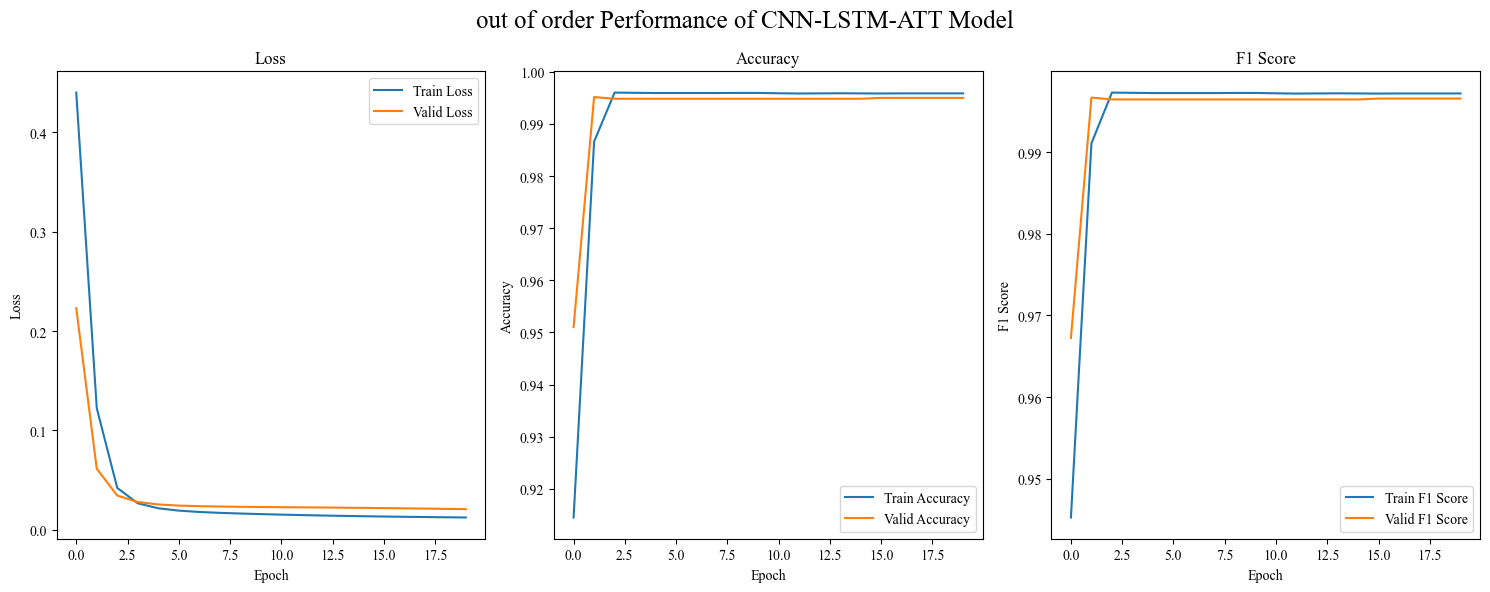

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

    # 绘制损失
axes[0].plot(model_train_losses, label='Train Loss')
axes[0].plot(model_valid_losses, label='Valid Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# 绘制准确率
axes[1].plot(model_train_accuracies, label='Train Accuracy')
axes[1].plot(model_valid_accuracies, label='Valid Accuracy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# 绘制F1分数
axes[2].plot(model_train_f1, label='Train F1 Score')
axes[2].plot(model_valid_f1, label='Valid F1 Score')
axes[2].set_title('F1 Score')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
plt.suptitle('out of order Performance of CNN-model-ATT Model', fontsize=18)

plt.tight_layout()
# plt.savefig(save_path)

In [ ]:
# test_dataloader = DataLoader(model_test_dataset, batch_size=batch_size, shuffle=False)
from tqdm import tqdm
test_preds = []
test_labels = []
with torch.no_grad():
#     start_time = time.time()
    for batch_data, batch_labels in tqdm(model_test_dataloader):
        inputs = batch_data.to(device)
        labels = batch_labels.to(device).long()
        labels = labels.reshape(-1)
        outputs = model(inputs)
        test_preds.extend(outputs.cpu().detach().numpy())
        test_labels.extend(labels.cpu().detach().numpy())
#     end_time = time.time()
# total_testing_time_ms = (end_time - start_time) * 1000
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)
test_accuracy = calculate_accuracy(torch.from_numpy(test_labels), torch.from_numpy(test_preds))
test_f1 = calculate_f1_score(torch.from_numpy(test_labels), torch.from_numpy(test_preds))
test_preds_tensor = torch.from_numpy(test_preds) if isinstance(test_preds, np.ndarray) else test_preds
_, predicted_labels = torch.max(test_preds_tensor, dim=1)
predicted_labels = predicted_labels.numpy()

# print(f"测试总时间: {total_testing_time_ms:.4f} ms")
print(f"测试ACC:{test_accuracy}")
print(f"测试F1:{test_f1}")

100%|██████████| 6/6 [00:00<00:00, 99.01it/s]

测试ACC:0.9967590925459129
测试F1:0.9978102189781022


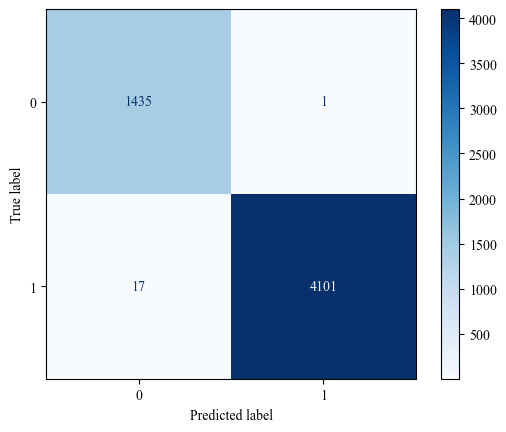

In [38]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('./test.png')

In [39]:

params = list(model.parameters())
k = 0
for i in params:
    l = 1
    print("该层的结构：" + str(list(i.size())))
    for j in i.size():
        l *= j
    print("该层参数和：" + str(l))
    k = k + l
print("总参数数量和：" + str(k))

该层的结构：[256, 14]
该层参数和：3584
该层的结构：[256, 64]
该层参数和：16384
该层的结构：[256]
该层参数和：256
该层的结构：[256]
该层参数和：256
该层的结构：[256, 14]
该层参数和：3584
该层的结构：[256, 64]
该层参数和：16384
该层的结构：[256]
该层参数和：256
该层的结构：[256]
该层参数和：256
该层的结构：[2, 128]
该层参数和：256
该层的结构：[2]
该层参数和：2
总参数数量和：41218
